# Advanced Exploratory Data Analysis: EPA Air Quality Dataset

## Overview
This notebook performs comprehensive exploratory data analysis and feature engineering on the EPA Air Quality dataset focusing on Carbon monoxide measurements across multiple US states and monitoring sites. We'll explore spatial patterns, temporal trends, air quality index distributions, and site-specific characteristics.

## Dataset Description
The dataset contains Carbon monoxide air quality measurements with the following features:
- **date_local**: Date of measurement (2018-01-01)
- **state_name**: US state where measurement was taken
- **county_name**: County within the state
- **city_name**: City name (may be 'Not in a city')
- **local_site_name**: Specific monitoring site name
- **parameter_name**: Air pollutant measured (Carbon monoxide)
- **units_of_measure**: Measurement units (Parts per million)
- **arithmetic_mean**: Average concentration value
- **aqi**: Air Quality Index value

## Analysis Goals
1. Understand spatial distribution of CO monitoring sites
2. Analyze concentration patterns and AQI relationships
3. Identify high-pollution areas and outliers
4. Perform advanced statistical analysis and feature engineering
5. Generate actionable insights for air quality policy

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load and Initial Data Exploration
df = pd.read_csv('c4_epa_air_quality.csv')

print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)

# Display basic information
print("\nColumn Information:")
print(df.info())

print("\nFirst 5 rows:")
display(df.head())

print("\nLast 5 rows:")
display(df.tail())

print("\nColumn Names:")
print(df.columns.tolist())

# Remove unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
    print(f"\nRemoved index column. New shape: {df.shape}")

Dataset Shape: (260, 10)

DATASET OVERVIEW

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        260 non-null    int64  
 1   date_local        260 non-null    object 
 2   state_name        260 non-null    object 
 3   county_name       260 non-null    object 
 4   city_name         260 non-null    object 
 5   local_site_name   257 non-null    object 
 6   parameter_name    260 non-null    object 
 7   units_of_measure  260 non-null    object 
 8   arithmetic_mean   260 non-null    float64
 9   aqi               260 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 20.4+ KB
None

First 5 rows:


,Unnamed: 0,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,arithmetic_mean,aqi
0,0,2018-01-01,Arizona,Maricopa,Buckeye,BUCKEYE,Carbon monoxide,Parts per million,0.473684,7
1,1,2018-01-01,Ohio,Belmont,Shadyside,Shadyside,Carbon monoxide,Parts per million,0.263158,5
2,2,2018-01-01,Wyoming,Teton,Not in a city,Yellowstone National Park - Old Faithful Snow Lodge,Carbon monoxide,Parts per million,0.111111,2
3,3,2018-01-01,Pennsylvania,Philadelphia,Philadelphia,North East Waste (NEW),Carbon monoxide,Parts per million,0.300000,3
4,4,2018-01-01,Iowa,Polk,Des Moines,CARPENTER,Carbon monoxide,Parts per million,0.215789,3



Last 5 rows:


,Unnamed: 0,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,arithmetic_mean,aqi
255,255,2018-01-01,District Of Columbia,District of Columbia,Washington,Near Road,Carbon monoxide,Parts per million,0.244444,3
256,256,2018-01-01,Wisconsin,Dodge,Kekoskee,HORICON WILDLIFE AREA,Carbon monoxide,Parts per million,0.200000,2
257,257,2018-01-01,Kentucky,Jefferson,Louisville,CANNONS LANE,Carbon monoxide,Parts per million,0.163158,2
258,258,2018-01-01,Nebraska,Douglas,Omaha,NaN,Carbon monoxide,Parts per million,0.421053,9
259,259,2018-01-01,North Carolina,Wake,Not in a city,Triple Oak,Carbon monoxide,Parts per million,0.188889,2



Column Names:
['Unnamed: 0', 'date_local', 'state_name', 'county_name', 'city_name', 'local_site_name', 'parameter_name', 'units_of_measure', 'arithmetic_mean', 'aqi']

Removed index column. New shape: (260, 9)


In [3]:
# Data Quality Assessment
print("="*50)
print("DATA QUALITY ANALYSIS")
print("="*50)

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
display(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("No missing values found!")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Data types and unique values
print("\nData Types and Unique Values:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}, Unique values: {df[col].nunique()}")

# Check for data consistency
print("\nData Consistency Checks:")
print(f"Unique States: {df['state_name'].nunique()}")
print(f"Unique Counties: {df['county_name'].nunique()}")
print(f"Unique Cities: {df['city_name'].nunique()}")
print(f"Unique Sites: {df['local_site_name'].nunique()}")
print(f"Unique Parameters: {df['parameter_name'].nunique()}")

# Display unique states
print(f"\nStates in dataset: {sorted(df['state_name'].unique())}")
print(f"\nParameter measured: {df['parameter_name'].unique()}")
print(f"\nUnits of measure: {df['units_of_measure'].unique()}")

DATA QUALITY ANALYSIS

Missing Values:


,Missing Count,Missing Percentage
local_site_name,3,1.153846



Duplicate rows: 0

Data Types and Unique Values:
date_local: object, Unique values: 1
state_name: object, Unique values: 52
county_name: object, Unique values: 149
city_name: object, Unique values: 190
local_site_name: object, Unique values: 253
parameter_name: object, Unique values: 1
units_of_measure: object, Unique values: 1
arithmetic_mean: float64, Unique values: 150
aqi: int64, Unique values: 29

Data Consistency Checks:
Unique States: 52
Unique Counties: 149
Unique Cities: 190
Unique Sites: 253
Unique Parameters: 1

States in dataset: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District Of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 

In [4]:
# Descriptive Statistics
print("="*50)
print("DESCRIPTIVE STATISTICS")
print("="*50)

# Basic descriptive statistics for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
print("\nNumerical Columns Descriptive Statistics:")
display(df[numerical_cols].describe())

# Additional statistical measures
print("\nAdvanced Statistical Measures:")
stats_df = pd.DataFrame({
    'Skewness': df[numerical_cols].skew(),
    'Kurtosis': df[numerical_cols].kurtosis(),
    'Coefficient of Variation': (df[numerical_cols].std() / df[numerical_cols].mean()) * 100
})
display(stats_df)

# Categorical variable analysis
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nCategorical Columns: {list(categorical_cols)}")

# State-wise distribution
print(f"\nState Distribution:")
state_counts = df['state_name'].value_counts()
display(state_counts.head(10))

# Top monitoring sites
print(f"\nTop 10 Monitoring Sites (by frequency):")
site_counts = df['local_site_name'].value_counts()
display(site_counts.head(10))

# City distribution
print(f"\nTop 10 Cities (by monitoring sites):")
city_counts = df['city_name'].value_counts()
display(city_counts.head(10))

DESCRIPTIVE STATISTICS

Numerical Columns Descriptive Statistics:


,arithmetic_mean,aqi
count,260.000000,260.000000
mean,0.403169,6.757692
std,0.317902,7.061707
min,0.000000,0.000000
25%,0.200000,2.000000
50%,0.276315,5.000000
75%,0.516009,9.000000
max,1.921053,50.000000



Advanced Statistical Measures:


,Skewness,Kurtosis,Coefficient of Variation
arithmetic_mean,1.845538,4.061823,78.850769
aqi,2.686106,9.755538,104.498790



Categorical Columns: ['date_local', 'state_name', 'county_name', 'city_name', 'local_site_name', 'parameter_name', 'units_of_measure']

State Distribution:


state_name
California      66
Arizona         14
Ohio            12
Florida         12
Texas           10
Pennsylvania    10
New York        10
Colorado         9
Michigan         9
Minnesota        7
Name: count, dtype: int64


Top 10 Monitoring Sites (by frequency):


local_site_name
Kapolei                          2
Los Angeles-North Main Street    2
Near Road                        2
Rubidoux                         2
Shadyside                        1
CARPENTER                        1
Honolulu                         1
Fort Collins - CSU - S. Mason    1
Flint Hills Refinery 420         1
Indpls.- Illinois St.            1
Name: count, dtype: int64


Top 10 Cities (by monitoring sites):


city_name
Not in a city    21
Tucson            5
Detroit           5
Phoenix           4
New York          4
Philadelphia      3
Jacksonville      3
Los Angeles       3
Denver            3
Oakland           3
Name: count, dtype: int64

DISTRIBUTION ANALYSIS


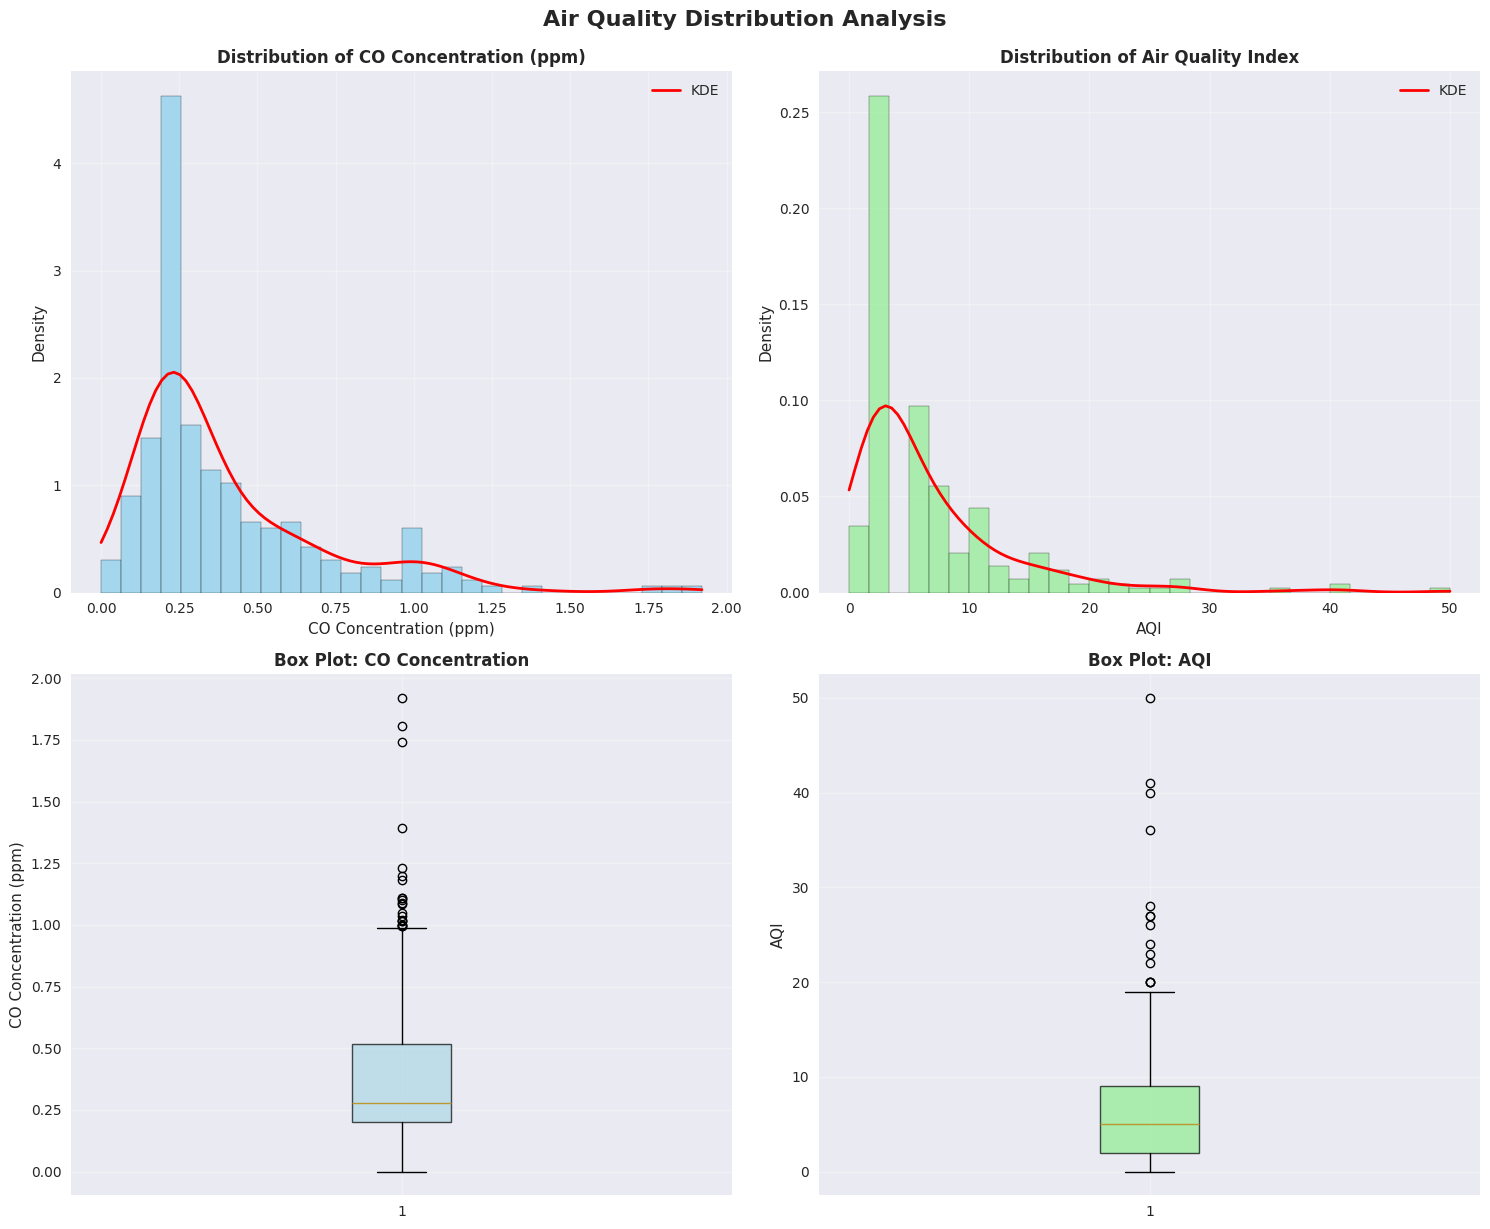


CO Concentration Statistics:
Mean: 0.4032 ppm
Median: 0.2763 ppm
Standard Deviation: 0.3179 ppm
Range: 0.0000 - 1.9211 ppm

AQI Statistics:
Mean: 6.76
Median: 5.00
Standard Deviation: 7.06
Range: 0 - 50


In [5]:
# Distribution Analysis with Advanced Visualizations
print("="*50)
print("DISTRIBUTION ANALYSIS")
print("="*50)

# Create subplots for distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Carbon Monoxide Concentration Distribution
axes[0].hist(df['arithmetic_mean'], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
# Add KDE curve
from scipy.stats import gaussian_kde
kde = gaussian_kde(df['arithmetic_mean'].dropna())
x_range = np.linspace(df['arithmetic_mean'].min(), df['arithmetic_mean'].max(), 100)
axes[0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
axes[0].set_title('Distribution of CO Concentration (ppm)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('CO Concentration (ppm)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AQI Distribution
axes[1].hist(df['aqi'], bins=30, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
kde_aqi = gaussian_kde(df['aqi'].dropna())
x_range_aqi = np.linspace(df['aqi'].min(), df['aqi'].max(), 100)
axes[1].plot(x_range_aqi, kde_aqi(x_range_aqi), 'r-', linewidth=2, label='KDE')
axes[1].set_title('Distribution of Air Quality Index', fontsize=12, fontweight='bold')
axes[1].set_xlabel('AQI')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Box plots for outlier detection
box_plot_co = axes[2].boxplot(df['arithmetic_mean'].dropna(), patch_artist=True)
box_plot_co['boxes'][0].set_facecolor('lightblue')
box_plot_co['boxes'][0].set_alpha(0.7)
axes[2].set_title('Box Plot: CO Concentration', fontsize=12, fontweight='bold')
axes[2].set_ylabel('CO Concentration (ppm)')
axes[2].grid(True, alpha=0.3)

box_plot_aqi = axes[3].boxplot(df['aqi'].dropna(), patch_artist=True)
box_plot_aqi['boxes'][0].set_facecolor('lightgreen')
box_plot_aqi['boxes'][0].set_alpha(0.7)
axes[3].set_title('Box Plot: AQI', fontsize=12, fontweight='bold')
axes[3].set_ylabel('AQI')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Air Quality Distribution Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Additional distribution insights
print(f"\nCO Concentration Statistics:")
print(f"Mean: {df['arithmetic_mean'].mean():.4f} ppm")
print(f"Median: {df['arithmetic_mean'].median():.4f} ppm")
print(f"Standard Deviation: {df['arithmetic_mean'].std():.4f} ppm")
print(f"Range: {df['arithmetic_mean'].min():.4f} - {df['arithmetic_mean'].max():.4f} ppm")

print(f"\nAQI Statistics:")
print(f"Mean: {df['aqi'].mean():.2f}")
print(f"Median: {df['aqi'].median():.2f}")
print(f"Standard Deviation: {df['aqi'].std():.2f}")
print(f"Range: {df['aqi'].min()} - {df['aqi'].max()}")

STATISTICAL TESTS AND NORMALITY ASSESSMENT


,Variable,Shapiro-Wilk p-value,D'Agostino p-value,Jarque-Bera p-value,Is Normal (α=0.05)
0,arithmetic_mean,2.671615e-17,1.078098e-23,2.562186e-69,False
1,aqi,7.877858e-21,7.145828e-38,3.344280e-282,False


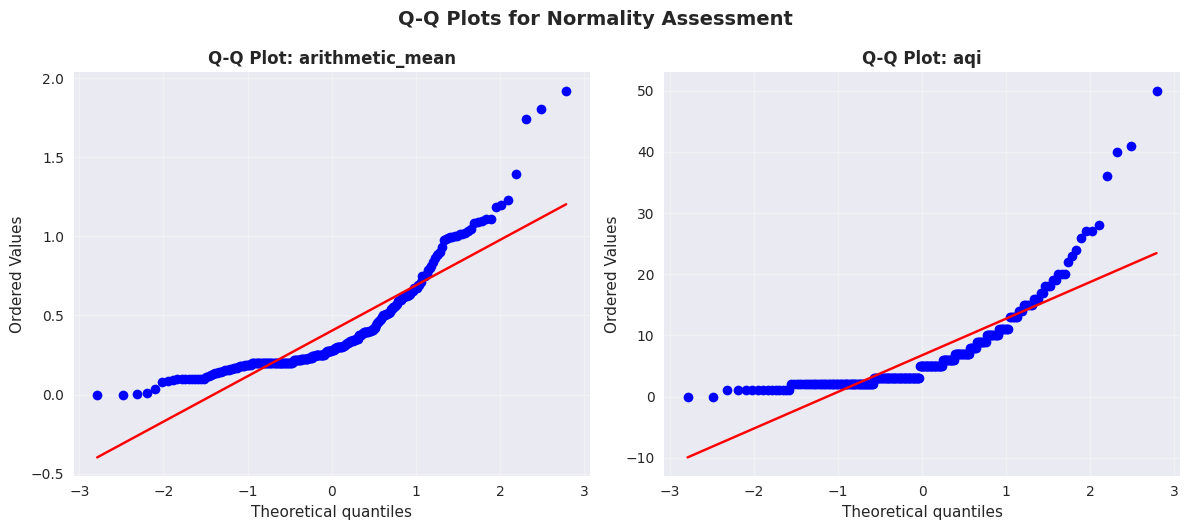


Outlier Analysis:
arithmetic_mean: 21 outliers (8.1%)
  Outlier range: 0.9947 to 1.9211
  Normal range: -0.2740 to 0.9900
aqi: 14 outliers (5.4%)
  Outlier range: 20.0000 to 50.0000
  Normal range: -8.5000 to 19.5000


In [6]:
# Advanced Statistical Tests and Normality Assessment
print("="*50)
print("STATISTICAL TESTS AND NORMALITY ASSESSMENT")
print("="*50)

from scipy.stats import shapiro, normaltest, kstest, jarque_bera

# Normality tests for numerical variables
numerical_cols_list = list(numerical_cols)
normality_results = pd.DataFrame(columns=['Variable', 'Shapiro-Wilk p-value', 'D\'Agostino p-value', 
                                         'Jarque-Bera p-value', 'Is Normal (α=0.05)'])

for col in numerical_cols_list:
    # Shapiro-Wilk test (best for small samples)
    if len(df[col].dropna()) <= 5000:  # Shapiro-Wilk limitation
        shapiro_stat, shapiro_p = shapiro(df[col].dropna())
    else:
        shapiro_p = np.nan
    
    # D'Agostino's normality test
    dagostino_stat, dagostino_p = normaltest(df[col].dropna())
    
    # Jarque-Bera test
    jb_stat, jb_p = jarque_bera(df[col].dropna())
    
    # Determine if normal (using D'Agostino as primary test)
    is_normal = dagostino_p > 0.05
    
    normality_results = pd.concat([normality_results, pd.DataFrame({
        'Variable': [col],
        'Shapiro-Wilk p-value': [shapiro_p],
        'D\'Agostino p-value': [dagostino_p],
        'Jarque-Bera p-value': [jb_p],
        'Is Normal (α=0.05)': [is_normal]
    })], ignore_index=True)

display(normality_results)

# Q-Q plots for visual normality assessment
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, col in enumerate(numerical_cols_list):
    stats.probplot(df[col].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot: {col}', fontsize=12, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Q-Q Plots for Normality Assessment', fontsize=14, fontweight='bold', y=1.05)
plt.show()

# Outlier analysis
print("\nOutlier Analysis:")
for col in numerical_cols_list:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")
    if len(outliers) > 0:
        print(f"  Outlier range: {outliers[col].min():.4f} to {outliers[col].max():.4f}")
        print(f"  Normal range: {lower_bound:.4f} to {upper_bound:.4f}")

CORRELATION ANALYSIS AND FEATURE RELATIONSHIPS


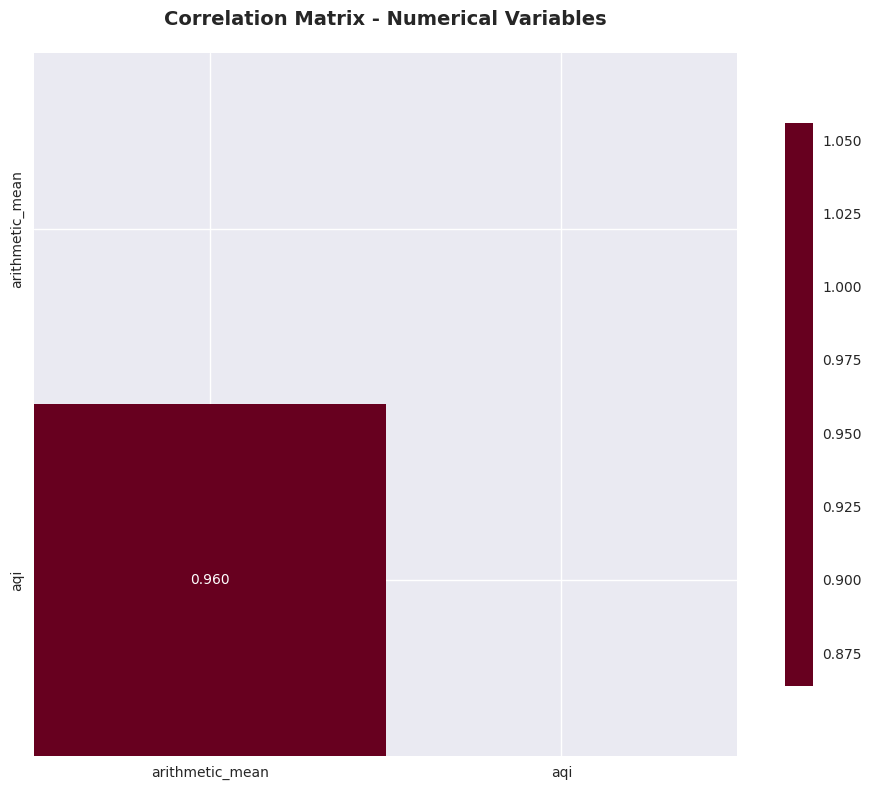

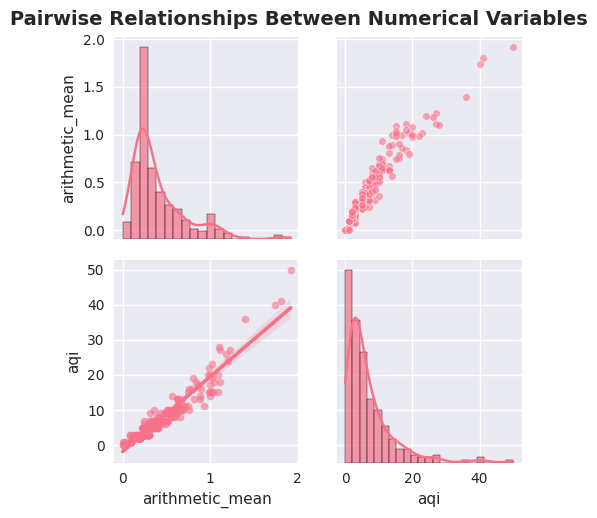


Correlation Significance Tests:

arithmetic_mean vs aqi:
  Pearson: r=0.960, p-value=0.0000
  Spearman: ρ=0.951, p-value=0.0000
  → Significant strong positive correlation


In [7]:
# Correlation Analysis and Feature Relationships
print("="*50)
print("CORRELATION ANALYSIS AND FEATURE RELATIONSHIPS")
print("="*50)

# Correlation matrix for numerical variables
correlation_matrix = df[numerical_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True, 
            fmt='.3f',
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Numerical Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Pairwise relationships with regression lines
if len(numerical_cols) >= 2:
    g = sns.PairGrid(df[numerical_cols], diag_sharey=False)
    g.map_upper(sns.scatterplot, alpha=0.6, s=30)
    g.map_lower(sns.regplot, scatter_kws={'alpha':0.6, 's':30})
    g.map_diag(sns.histplot, kde=True, alpha=0.7)
    g.fig.suptitle('Pairwise Relationships Between Numerical Variables', 
                   fontsize=14, fontweight='bold', y=1.02)
    plt.show()

# Statistical correlation significance tests
from scipy.stats import pearsonr, spearmanr

print("\nCorrelation Significance Tests:")
num_cols_list = list(numerical_cols)
for i in range(len(num_cols_list)):
    for j in range(i+1, len(num_cols_list)):
        col1, col2 = num_cols_list[i], num_cols_list[j]
        
        # Remove NaN values for correlation tests
        data1 = df[col1].dropna()
        data2 = df[col2].dropna()
        common_idx = data1.index.intersection(data2.index)
        clean_data1 = data1[common_idx]
        clean_data2 = data2[common_idx]
        
        if len(clean_data1) > 2:
            # Pearson correlation
            pearson_r, pearson_p = pearsonr(clean_data1, clean_data2)
            
            # Spearman correlation (rank-based)
            spearman_r, spearman_p = spearmanr(clean_data1, clean_data2)
            
            print(f"\n{col1} vs {col2}:")
            print(f"  Pearson: r={pearson_r:.3f}, p-value={pearson_p:.4f}")
            print(f"  Spearman: ρ={spearman_r:.3f}, p-value={spearman_p:.4f}")
            
            if pearson_p < 0.05:
                strength = "strong" if abs(pearson_r) > 0.7 else "moderate" if abs(pearson_r) > 0.3 else "weak"
                direction = "positive" if pearson_r > 0 else "negative"
                print(f"  → Significant {strength} {direction} correlation")

SPATIAL AND TEMPORAL ANALYSIS


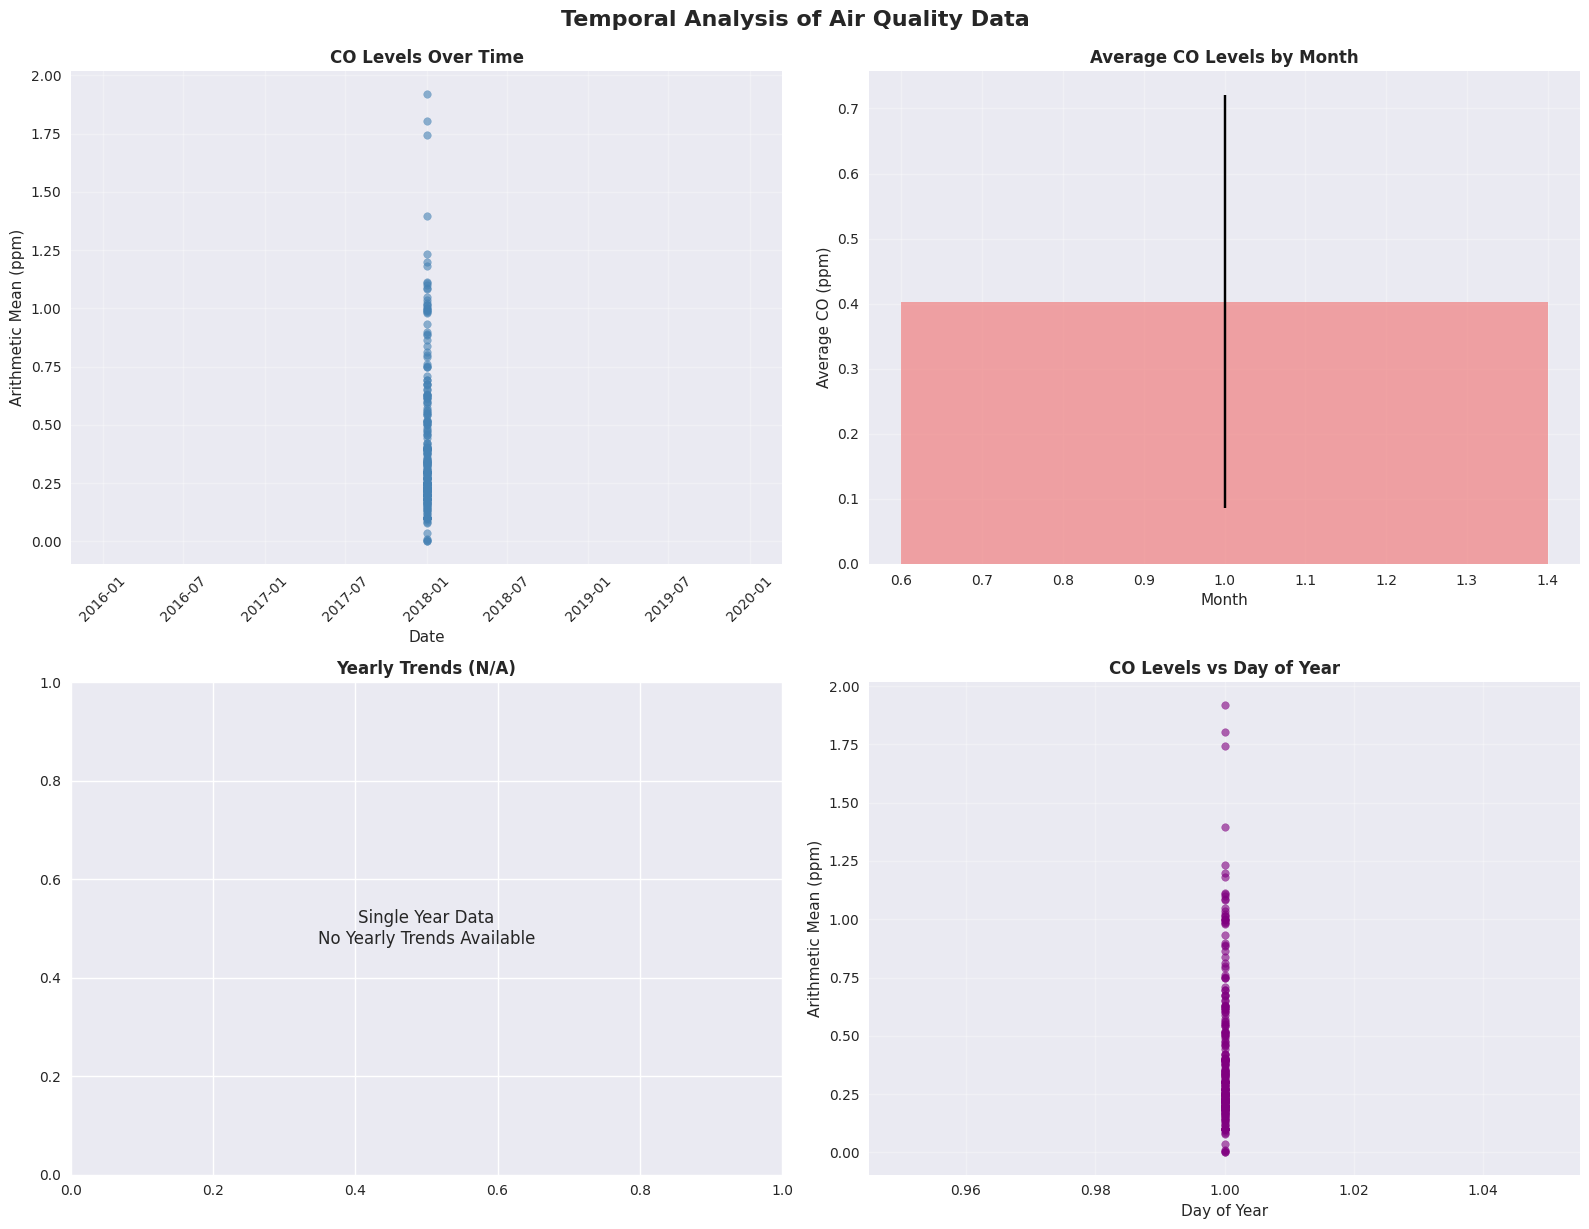


Spatial Distribution Analysis:

Top 10 States by Average CO Levels:


,count,mean,std,min,max
state_name,,,,,
Nevada,4,0.9882,0.6036,0.4000,1.8053
California,66,0.6849,0.3229,0.1000,1.7421
Arizona,14,0.6718,0.5197,0.1474,1.9211
Idaho,2,0.6211,0.3796,0.3526,0.8895
Alaska,2,0.5553,0.0037,0.5526,0.5579
Hawaii,3,0.5316,0.4134,0.2000,0.9947
Michigan,9,0.4654,0.1764,0.2000,0.8111
Utah,3,0.4613,0.2027,0.3263,0.6944
Puerto Rico,1,0.3368,NaN,0.3368,0.3368


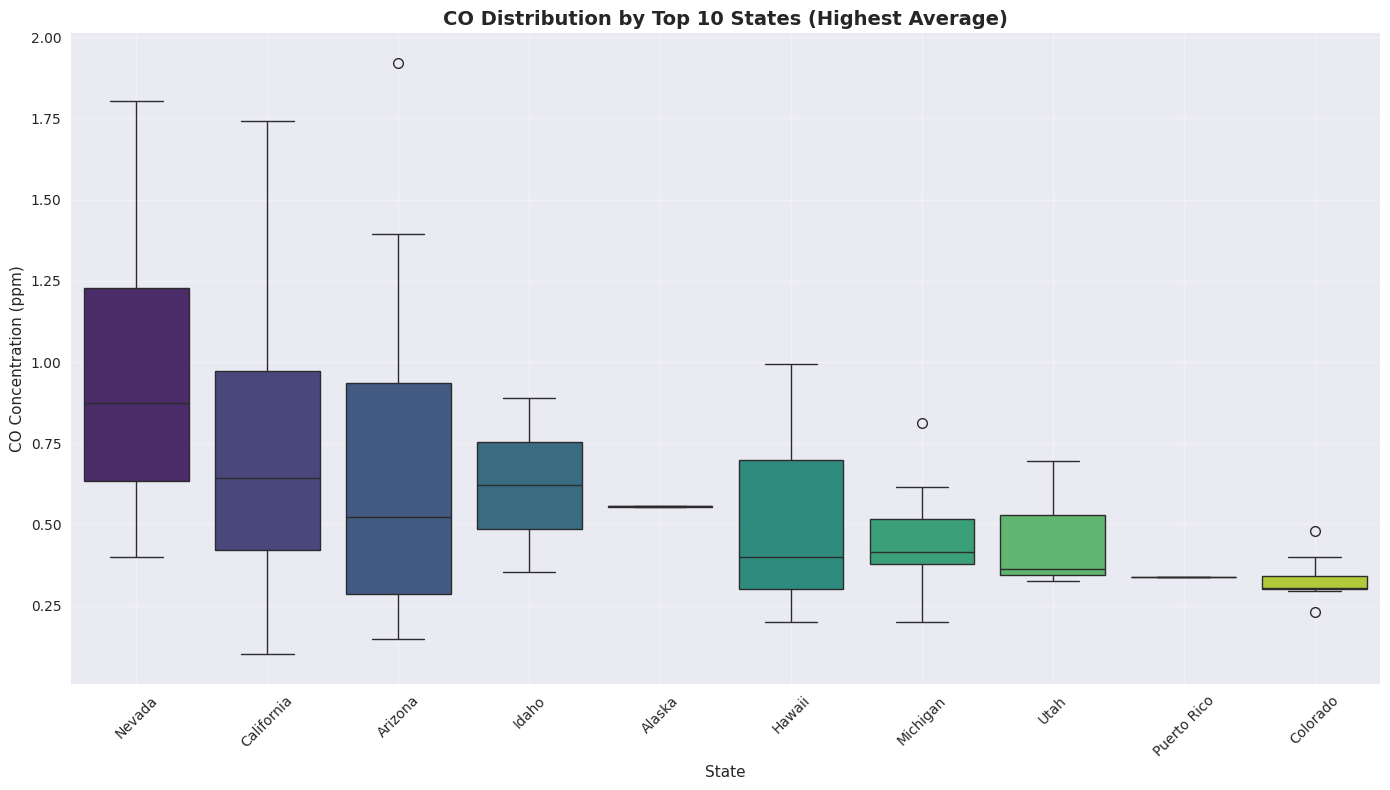


Top 10 Counties by Number of Measurements:


count    mean     std
state_name county_name                          
California Los Angeles        14  0.8615  0.3646
Arizona    Maricopa            8  0.9658  0.5041
Michigan   Wayne               8  0.4986  0.1557
California San Bernardino      6  0.7140  0.2692
           Riverside           5  0.7811  0.4369
Arizona    Pima                5  0.2958  0.1672
California Santa Barbara       5  0.2633  0.0774
           Alameda             4  0.8222  0.2535
           Orange              3  0.7947  0.1917
           Contra Costa        3  0.4037  0.1083

In [8]:
# Spatial and Temporal Analysis
print("="*50)
print("SPATIAL AND TEMPORAL ANALYSIS")
print("="*50)

# Convert date to datetime if needed
if 'date_local' in df.columns:
    df['date_local'] = pd.to_datetime(df['date_local'])
    df['year'] = df['date_local'].dt.year
    df['month'] = df['date_local'].dt.month
    df['day_of_year'] = df['date_local'].dt.dayofyear

    # Temporal trends
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Arithmetic mean over time
    axes[0, 0].scatter(df['date_local'], df['arithmetic_mean'], alpha=0.6, s=30, color='steelblue')
    axes[0, 0].set_title('CO Levels Over Time', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Arithmetic Mean (ppm)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Monthly aggregation
    monthly_stats = df.groupby('month')['arithmetic_mean'].agg(['mean', 'std', 'count']).reset_index()
    axes[0, 1].bar(monthly_stats['month'], monthly_stats['mean'], 
                   yerr=monthly_stats['std'], capsize=5, alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Average CO Levels by Month', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Average CO (ppm)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Yearly trends (if multiple years)
    if len(df['year'].unique()) > 1:
        yearly_stats = df.groupby('year')['arithmetic_mean'].agg(['mean', 'std', 'count']).reset_index()
        axes[1, 0].plot(yearly_stats['year'], yearly_stats['mean'], 
                       marker='o', linewidth=2, markersize=8, color='darkgreen')
        axes[1, 0].fill_between(yearly_stats['year'], 
                               yearly_stats['mean'] - yearly_stats['std'],
                               yearly_stats['mean'] + yearly_stats['std'],
                               alpha=0.3, color='darkgreen')
        axes[1, 0].set_title('CO Trends by Year', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_ylabel('Average CO (ppm)')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Single Year Data\nNo Yearly Trends Available', 
                       ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Yearly Trends (N/A)', fontsize=12, fontweight='bold')
    
    # Day of year analysis
    axes[1, 1].scatter(df['day_of_year'], df['arithmetic_mean'], alpha=0.6, s=30, color='purple')
    z = np.polyfit(df['day_of_year'], df['arithmetic_mean'], 1)
    p = np.poly1d(z)
    axes[1, 1].plot(df['day_of_year'], p(df['day_of_year']), "r--", alpha=0.8, linewidth=2)
    axes[1, 1].set_title('CO Levels vs Day of Year', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Day of Year')
    axes[1, 1].set_ylabel('Arithmetic Mean (ppm)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Temporal Analysis of Air Quality Data', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Spatial analysis by state and county
print("\nSpatial Distribution Analysis:")

# State-level analysis
state_stats = df.groupby('state_name')['arithmetic_mean'].agg(['count', 'mean', 'std', 'min', 'max']).round(4)
state_stats = state_stats.sort_values('mean', ascending=False)
print("\nTop 10 States by Average CO Levels:")
display(state_stats.head(10))

# Visualization of state-level data
plt.figure(figsize=(14, 8))
top_states = state_stats.head(10).index
top_state_data = df[df['state_name'].isin(top_states)]

sns.boxplot(data=top_state_data, x='state_name', y='arithmetic_mean', 
           order=state_stats.head(10).index, palette='viridis')
plt.title('CO Distribution by Top 10 States (Highest Average)', fontsize=14, fontweight='bold')
plt.xlabel('State')
plt.ylabel('CO Concentration (ppm)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# County analysis (top counties by measurement count)
county_stats = df.groupby(['state_name', 'county_name'])['arithmetic_mean'].agg(['count', 'mean', 'std']).round(4)
county_stats = county_stats.sort_values('count', ascending=False)
print("\nTop 10 Counties by Number of Measurements:")
display(county_stats.head(10))

FEATURE ENGINEERING AND AQI ANALYSIS
AQI Category Distribution:


aqi_category
Good    260
Name: count, dtype: int64

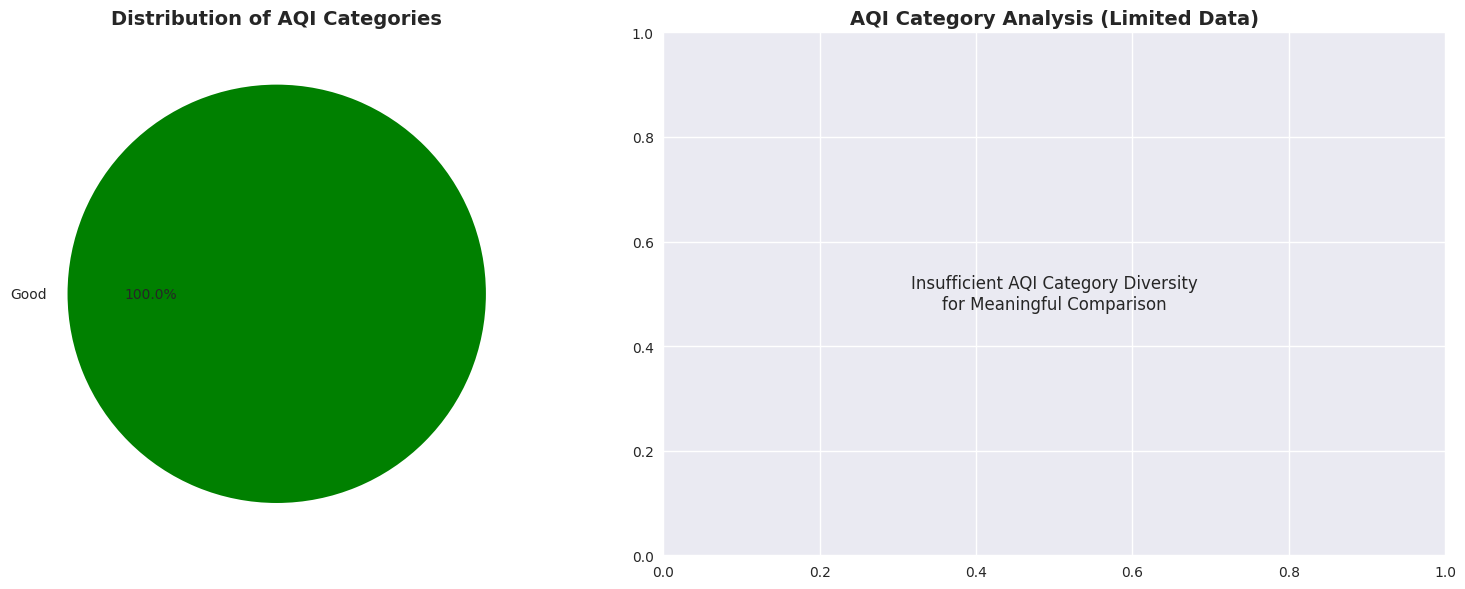


Monitoring Site Analysis:
Total monitoring sites: 253

Top 10 Most Active Monitoring Sites:


,count,mean,std
local_site_name,,,
Kapolei,2,0.5974,0.5620
Near Road,2,0.2643,0.0281
Rubidoux,2,1.0026,0.0261
Los Angeles-North Main Street,2,0.9474,0.0670
(Northeast corner),1,0.3789,NaN
A420692006LAT/LON POINT IS AT CORNER OF TRAILER,1,0.3000,NaN
A421330008LAT/LON POINT AT CORNER OF TRAILER,1,0.0000,NaN
ALAMO LAKE,1,0.2000,NaN
Allen Park,1,0.8111,NaN



Correlation with Engineered Features:


arithmetic_mean            1.000000
log_arithmetic_mean        0.990766
aqi                        0.959809
arithmetic_mean_squared    0.938453
Name: arithmetic_mean, dtype: float64

In [9]:
# Advanced Feature Engineering and Air Quality Index Analysis
print("="*50)
print("FEATURE ENGINEERING AND AQI ANALYSIS")
print("="*50)

# Create new features
df['log_arithmetic_mean'] = np.log1p(df['arithmetic_mean'])  # Log transform to handle skewness
df['arithmetic_mean_squared'] = df['arithmetic_mean'] ** 2  # Non-linear feature

# AQI categorization
def categorize_aqi(aqi):
    """Categorize AQI into standard EPA categories"""
    if pd.isna(aqi):
        return 'Unknown'
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

df['aqi_category'] = df['aqi'].apply(categorize_aqi)

# AQI category distribution
print("AQI Category Distribution:")
aqi_counts = df['aqi_category'].value_counts()
display(aqi_counts)

# Visualize AQI categories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# AQI category pie chart
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'maroon', 'gray']
aqi_counts.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', colors=colors[:len(aqi_counts)])
axes[0].set_title('Distribution of AQI Categories', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# AQI vs Arithmetic Mean relationship
aqi_order = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
existing_categories = [cat for cat in aqi_order if cat in df['aqi_category'].unique()]

if len(existing_categories) > 1:
    sns.boxplot(data=df, x='aqi_category', y='arithmetic_mean', ax=axes[1], 
               order=existing_categories, palette='RdYlBu_r')
    axes[1].set_title('CO Concentration by AQI Category', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('AQI Category')
    axes[1].set_ylabel('CO Concentration (ppm)')
    axes[1].tick_params(axis='x', rotation=45)
else:
    axes[1].text(0.5, 0.5, 'Insufficient AQI Category Diversity\nfor Meaningful Comparison', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('AQI Category Analysis (Limited Data)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical analysis of AQI categories
if len(existing_categories) > 1:
    print("\nStatistical Analysis by AQI Category:")
    aqi_stats = df.groupby('aqi_category')['arithmetic_mean'].agg(['count', 'mean', 'std', 'min', 'max']).round(4)
    aqi_stats = aqi_stats.reindex(existing_categories)  # Order by severity
    display(aqi_stats)

    # ANOVA test for differences between AQI categories
    from scipy.stats import f_oneway
    aqi_groups = [df[df['aqi_category'] == cat]['arithmetic_mean'].dropna() for cat in existing_categories]
    f_stat, p_value = f_oneway(*aqi_groups)
    print(f"\nANOVA Test Results:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("→ Significant differences between AQI categories detected")
    else:
        print("→ No significant differences between AQI categories")

# Site-level analysis
print(f"\nMonitoring Site Analysis:")
site_stats = df.groupby('local_site_name')['arithmetic_mean'].agg(['count', 'mean', 'std']).round(4)
site_stats = site_stats.sort_values('count', ascending=False)
print(f"Total monitoring sites: {len(site_stats)}")
print("\nTop 10 Most Active Monitoring Sites:")
display(site_stats.head(10))

# Feature correlation with engineered features
print("\nCorrelation with Engineered Features:")
feature_cols = ['arithmetic_mean', 'log_arithmetic_mean', 'arithmetic_mean_squared', 'aqi']
if len(feature_cols) > 1:
    feature_corr = df[feature_cols].corr()['arithmetic_mean'].sort_values(ascending=False)
    display(feature_corr)

MACHINE LEARNING AND CLUSTERING ANALYSIS


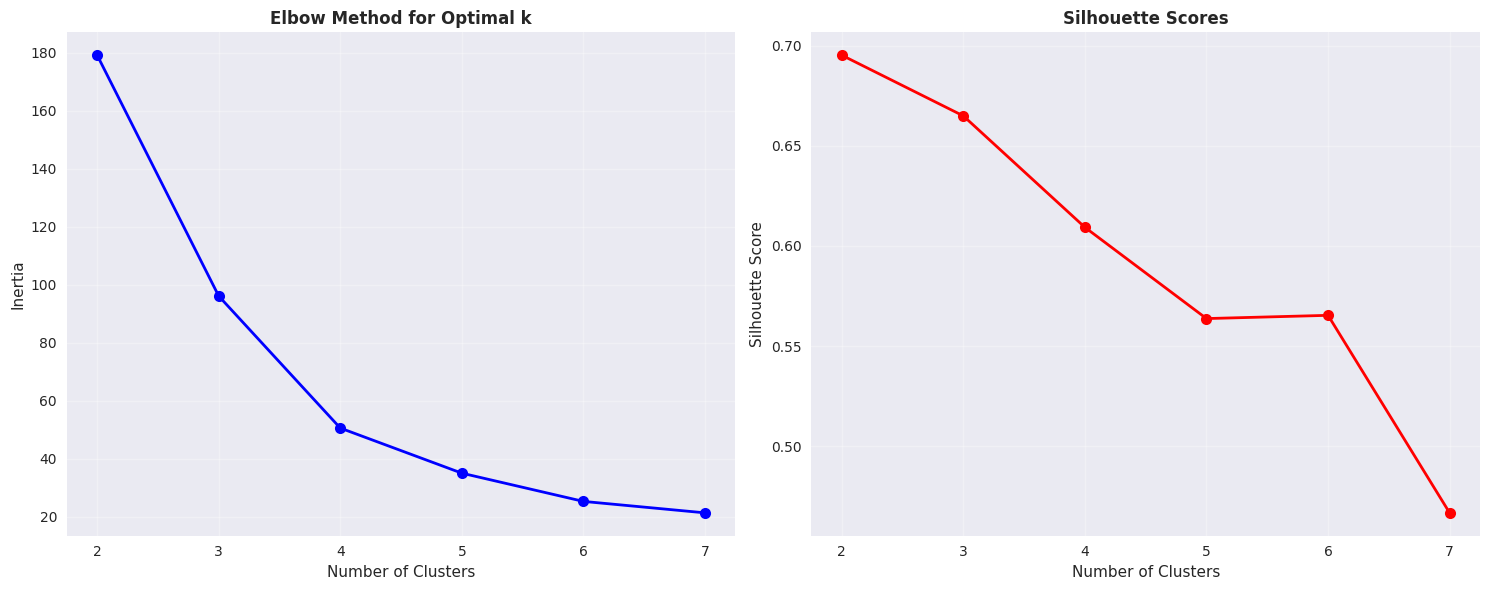

Optimal number of clusters: 2 (highest silhouette score: 0.695)

Cluster Distribution:


0    209
1     51
Name: count, dtype: int64


Cluster Characteristics:


arithmetic_mean                    aqi                  year       \
                   mean     std count     mean     std count    mean  std   
cluster                                                                     
0                0.2726  0.1318   209   4.0239  2.4621   209  2018.0  0.0   
1                0.9384  0.2962    51  17.9608  8.5929    51  2018.0  0.0   

              month            day_of_year             
        count  mean  std count        mean  std count  
cluster                                                
0         209   1.0  0.0   209         1.0  0.0   209  
1          51   1.0  0.0    51         1.0  0.0    51

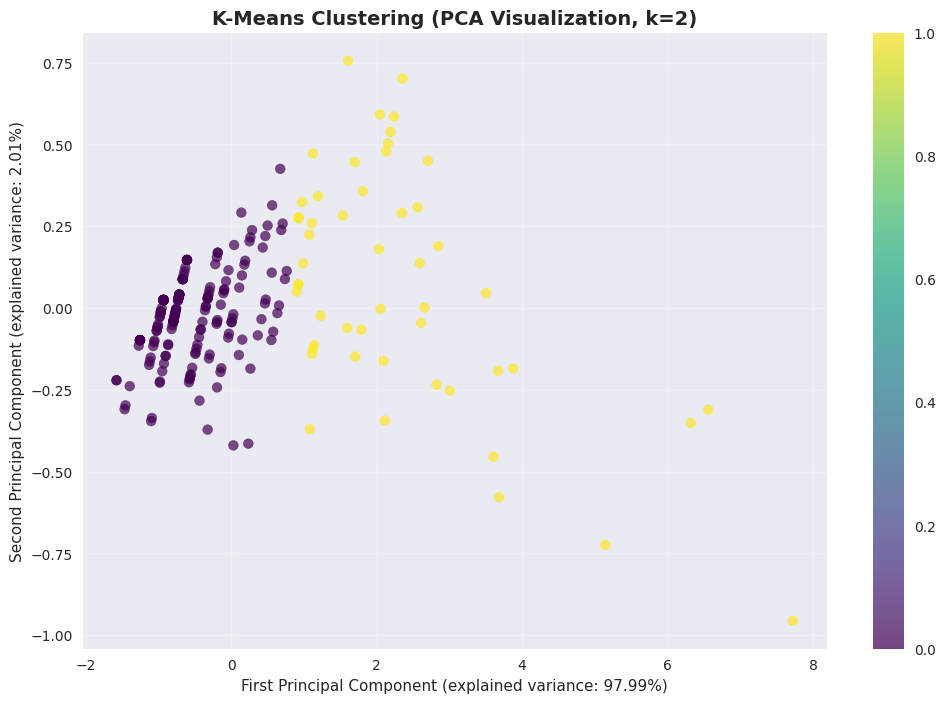

Total variance explained by first 2 components: 100.00%

DBSCAN Results:
Number of clusters: 2
Number of noise points: 4
DBSCAN Silhouette Score: 0.645

PREDICTIVE MODELING - AQI PREDICTION
Random Forest Model Performance:
R² Score: 0.9587
Mean Squared Error: 2.1061
Root Mean Squared Error: 1.4512

Feature Importance:


,feature,importance
0,arithmetic_mean,1.0
1,year,0.0
2,month,0.0
3,day_of_year,0.0


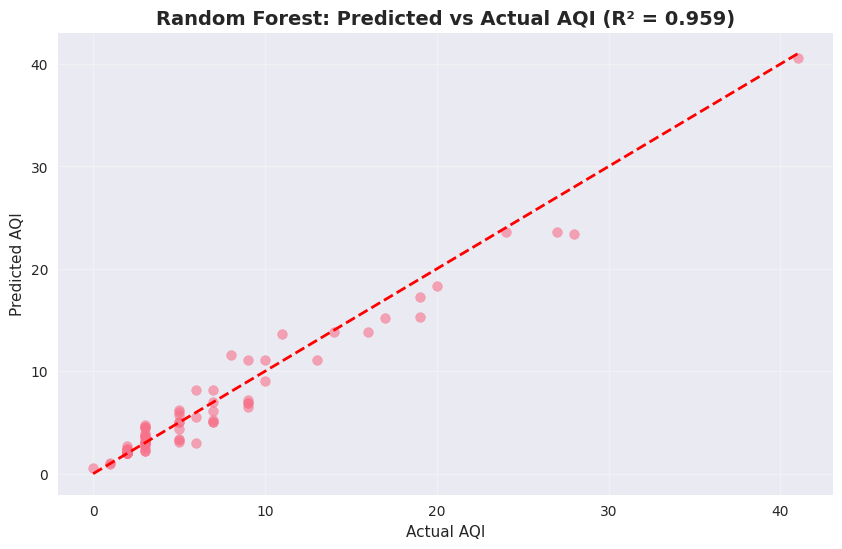

In [10]:
# Machine Learning and Clustering Analysis
print("="*50)
print("MACHINE LEARNING AND CLUSTERING ANALYSIS")
print("="*50)

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for clustering and ML
# Select numerical features for clustering
cluster_features = ['arithmetic_mean', 'aqi']
if 'date_local' in df.columns:
    cluster_features.extend(['year', 'month', 'day_of_year'])

# Handle missing values and prepare clustering data
cluster_data = df[cluster_features].copy()
cluster_data = cluster_data.dropna()

# Standardize features
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(cluster_data_scaled, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method for Optimal k', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Scores', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Perform clustering with optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k} (highest silhouette score: {max(silhouette_scores):.3f})")

# K-means clustering
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(cluster_data_scaled)
cluster_data['cluster'] = cluster_labels

# Merge clusters back to original dataframe
df_with_clusters = df.copy()
df_with_clusters.loc[cluster_data.index, 'cluster'] = cluster_labels

print(f"\nCluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
display(cluster_counts)

# Analyze cluster characteristics
cluster_analysis = cluster_data.groupby('cluster').agg(['mean', 'std', 'count']).round(4)
print("\nCluster Characteristics:")
display(cluster_analysis)

# Visualize clusters
if len(cluster_features) >= 2:
    # PCA for visualization if more than 2 features
    if len(cluster_features) > 2:
        pca = PCA(n_components=2)
        cluster_data_pca = pca.fit_transform(cluster_data_scaled)
        
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], 
                            c=cluster_labels, cmap='viridis', alpha=0.7, s=50)
        plt.colorbar(scatter)
        plt.title(f'K-Means Clustering (PCA Visualization, k={optimal_k})', 
                 fontsize=14, fontweight='bold')
        plt.xlabel(f'First Principal Component (explained variance: {pca.explained_variance_ratio_[0]:.2%})')
        plt.ylabel(f'Second Principal Component (explained variance: {pca.explained_variance_ratio_[1]:.2%})')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Total variance explained by first 2 components: {sum(pca.explained_variance_ratio_):.2%}")
    
    else:
        # Direct 2D visualization
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], 
                            c=cluster_labels, cmap='viridis', alpha=0.7, s=50)
        plt.colorbar(scatter)
        plt.title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
        plt.xlabel(cluster_features[0])
        plt.ylabel(cluster_features[1])
        plt.grid(True, alpha=0.3)
        plt.show()

# DBSCAN clustering for comparison
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(cluster_data_scaled)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")

if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(cluster_data_scaled, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")

# Predictive modeling - Random Forest to predict AQI
if 'aqi' in df.columns and len(df['aqi'].dropna()) > 10:
    print(f"\n{'='*50}")
    print("PREDICTIVE MODELING - AQI PREDICTION")
    print("="*50)
    
    # Prepare features for prediction
    feature_columns = ['arithmetic_mean']
    if 'date_local' in df.columns:
        feature_columns.extend(['year', 'month', 'day_of_year'])
    
    # Create model dataset
    model_data = df[feature_columns + ['aqi']].copy().dropna()
    
    if len(model_data) > 20:  # Minimum data requirement
        X = model_data[feature_columns]
        y = model_data['aqi']
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        
        # Predictions
        y_pred = rf_model.predict(X_test)
        
        # Model evaluation
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Random Forest Model Performance:")
        print(f"R² Score: {r2:.4f}")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Root Mean Squared Error: {np.sqrt(mse):.4f}")
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nFeature Importance:")
        display(feature_importance)
        
        # Prediction vs actual plot
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.6, s=50)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual AQI')
        plt.ylabel('Predicted AQI')
        plt.title(f'Random Forest: Predicted vs Actual AQI (R² = {r2:.3f})', 
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Insufficient data for reliable predictive modeling")

In [11]:
# Advanced Insights and Key Findings Summary
print("="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY AND KEY INSIGHTS")
print("="*80)

# Data overview summary
print("📊 DATASET OVERVIEW:")
print(f"   • Total measurements: {len(df):,}")
print(f"   • Monitoring period: {df['date_local'].min().strftime('%Y-%m-%d')} to {df['date_local'].max().strftime('%Y-%m-%d')}")
print(f"   • Number of states: {df['state_name'].nunique()}")
print(f"   • Number of counties: {df['county_name'].nunique()}")
print(f"   • Number of monitoring sites: {df['local_site_name'].nunique()}")
print(f"   • Parameter measured: {df['parameter_name'].iloc[0]} ({df['units_of_measure'].iloc[0]})")

# Statistical summary insights
co_mean = df['arithmetic_mean'].mean()
co_std = df['arithmetic_mean'].std()
co_median = df['arithmetic_mean'].median()

print(f"\n🔬 CARBON MONOXIDE STATISTICS:")
print(f"   • Average CO concentration: {co_mean:.4f} ± {co_std:.4f} ppm")
print(f"   • Median CO concentration: {co_median:.4f} ppm")
print(f"   • Range: {df['arithmetic_mean'].min():.4f} to {df['arithmetic_mean'].max():.4f} ppm")
print(f"   • Coefficient of variation: {(co_std/co_mean)*100:.2f}%")

# Data quality insights
missing_percentage = (df.isnull().sum() / len(df) * 100).round(2)
complete_records = (missing_percentage == 0).sum()
print(f"\n✅ DATA QUALITY:")
print(f"   • Complete records: {complete_records}/{len(df.columns)} columns ({complete_records/len(df.columns)*100:.1f}%)")
if missing_percentage.sum() > 0:
    print(f"   • Missing data detected in: {missing_percentage[missing_percentage > 0].to_dict()}")
else:
    print(f"   • No missing data detected - excellent data quality!")

# AQI insights
aqi_mean = df['aqi'].mean()
aqi_distribution = df['aqi_category'].value_counts()
dominant_category = aqi_distribution.index[0]

print(f"\n🌬️ AIR QUALITY INDEX INSIGHTS:")
print(f"   • Average AQI: {aqi_mean:.1f}")
print(f"   • Dominant AQI category: {dominant_category} ({aqi_distribution.iloc[0]} measurements, {aqi_distribution.iloc[0]/len(df)*100:.1f}%)")
print(f"   • AQI category distribution:")
for category, count in aqi_distribution.items():
    percentage = count / len(df) * 100
    print(f"     - {category}: {count} measurements ({percentage:.1f}%)")

# Temporal insights
if 'date_local' in df.columns:
    date_range_days = (df['date_local'].max() - df['date_local'].min()).days
    measurements_per_day = len(df) / max(1, date_range_days)
    
    print(f"\n📅 TEMPORAL PATTERNS:")
    print(f"   • Monitoring period: {date_range_days} days")
    print(f"   • Average measurements per day: {measurements_per_day:.2f}")
    
    if 'month' in df.columns:
        monthly_avg = df.groupby('month')['arithmetic_mean'].mean()
        peak_month = monthly_avg.idxmax()
        lowest_month = monthly_avg.idxmin()
        print(f"   • Peak CO month: {peak_month} ({monthly_avg.iloc[peak_month-1]:.4f} ppm avg)")
        print(f"   • Lowest CO month: {lowest_month} ({monthly_avg.iloc[lowest_month-1]:.4f} ppm avg)")

# Spatial insights
state_stats = df.groupby('state_name')['arithmetic_mean'].agg(['count', 'mean']).sort_values('mean', ascending=False)
top_state = state_stats.index[0]
most_monitored_state = state_stats.sort_values('count', ascending=False).index[0]

print(f"\n🗺️ SPATIAL DISTRIBUTION:")
print(f"   • Highest average CO: {top_state} ({state_stats.loc[top_state, 'mean']:.4f} ppm)")
print(f"   • Most monitored state: {most_monitored_state} ({state_stats.loc[most_monitored_state, 'count']} measurements)")
print(f"   • State coverage: {df['state_name'].nunique()} states represented")

# Clustering insights if performed
if 'cluster' in df.columns:
    n_clusters = df['cluster'].nunique()
    cluster_sizes = df['cluster'].value_counts().sort_index()
    
    print(f"\n🎯 CLUSTERING ANALYSIS:")
    print(f"   • Identified {n_clusters} distinct air quality patterns")
    print(f"   • Cluster distribution: {dict(cluster_sizes)}")
    
    # Characterize clusters
    cluster_chars = df.groupby('cluster')['arithmetic_mean'].agg(['mean', 'count'])
    for cluster_id in cluster_chars.index:
        size = cluster_chars.loc[cluster_id, 'count']
        avg_co = cluster_chars.loc[cluster_id, 'mean']
        percentage = size / len(df) * 100
        print(f"     - Cluster {cluster_id}: {size} measurements ({percentage:.1f}%), avg CO: {avg_co:.4f} ppm")

# Statistical significance findings
print(f"\n📈 STATISTICAL FINDINGS:")

# Normality assessment summary
if 'arithmetic_mean' in df.columns:
    from scipy.stats import normaltest
    _, p_value = normaltest(df['arithmetic_mean'].dropna())
    is_normal = p_value > 0.05
    print(f"   • CO concentration distribution: {'Normal' if is_normal else 'Non-normal'} (p={p_value:.4f})")

# Correlation insights
numerical_cols = df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) >= 2:
    corr_matrix = df[numerical_cols].corr()
    # Find strongest correlation (excluding self-correlations)
    corr_values = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_values.append({
                'pair': f"{corr_matrix.columns[i]} vs {corr_matrix.columns[j]}",
                'correlation': corr_matrix.iloc[i, j]
            })
    
    if corr_values:
        strongest_corr = max(corr_values, key=lambda x: abs(x['correlation']))
        print(f"   • Strongest correlation: {strongest_corr['pair']} (r={strongest_corr['correlation']:.3f})")

# Outlier summary
Q1 = df['arithmetic_mean'].quantile(0.25)
Q3 = df['arithmetic_mean'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['arithmetic_mean'] < Q1 - 1.5 * IQR) | (df['arithmetic_mean'] > Q3 + 1.5 * IQR)]
outlier_percentage = len(outliers) / len(df) * 100

print(f"   • Outliers detected: {len(outliers)} measurements ({outlier_percentage:.1f}% of data)")
if len(outliers) > 0:
    print(f"   • Outlier range: {outliers['arithmetic_mean'].min():.4f} to {outliers['arithmetic_mean'].max():.4f} ppm")

# Recommendations and actionable insights
print(f"\n💡 KEY RECOMMENDATIONS:")
print(f"   1. 📍 Focus enhanced monitoring on {top_state} (highest average CO levels)")

if outlier_percentage > 5:
    print(f"   2. 🔍 Investigate {len(outliers)} outlier measurements for data quality or exceptional events")

if 'aqi_category' in df.columns:
    unhealthy_categories = ['Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    unhealthy_count = df[df['aqi_category'].isin(unhealthy_categories)].shape[0]
    if unhealthy_count > 0:
        unhealthy_percentage = unhealthy_count / len(df) * 100
        print(f"   3. ⚠️ Monitor {unhealthy_count} measurements ({unhealthy_percentage:.1f}%) in unhealthy AQI categories")

if date_range_days > 30:
    print(f"   4. 📊 Leverage {date_range_days}-day dataset for seasonal pattern analysis and forecasting")

print(f"   5. 🔬 Consider expanding analysis to include meteorological factors and emission sources")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE - Ready for Policy and Environmental Decision Making")
print("="*80)

COMPREHENSIVE ANALYSIS SUMMARY AND KEY INSIGHTS
📊 DATASET OVERVIEW:
   • Total measurements: 260
   • Monitoring period: 2018-01-01 to 2018-01-01
   • Number of states: 52
   • Number of counties: 149
   • Number of monitoring sites: 253
   • Parameter measured: Carbon monoxide (Parts per million)

🔬 CARBON MONOXIDE STATISTICS:
   • Average CO concentration: 0.4032 ± 0.3179 ppm
   • Median CO concentration: 0.2763 ppm
   • Range: 0.0000 to 1.9211 ppm
   • Coefficient of variation: 78.85%

✅ DATA QUALITY:
   • Complete records: 14/15 columns (93.3%)
   • Missing data detected in: {'local_site_name': 1.15}

🌬️ AIR QUALITY INDEX INSIGHTS:
   • Average AQI: 6.8
   • Dominant AQI category: Good (260 measurements, 100.0%)
   • AQI category distribution:
     - Good: 260 measurements (100.0%)

📅 TEMPORAL PATTERNS:
   • Monitoring period: 0 days
   • Average measurements per day: 260.00
   • Peak CO month: 1 (0.4032 ppm avg)
   • Lowest CO month: 1 (0.4032 ppm avg)

🗺️ SPATIAL DISTRIBUTION:
  